In [216]:
import pandas as pd

df = pd.read_csv("2024president.csv")


important_columns = [
    "STATE",
    "ELECTORAL VOTES",
    "ELECTORAL VOTE: TRUMP (R)",
    "ELECTORAL VOTE: HARRIS (D)",
    "TRUMP",
    "HARRIS"
]

df = df[important_columns].iloc[:52]

columns_to_convert = [
    "ELECTORAL VOTES",
    "ELECTORAL VOTE: TRUMP (R)",
    "ELECTORAL VOTE: HARRIS (D)",
    "TRUMP",
    "HARRIS"
]


state_abbrev_to_name = {
    'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas',
    'CA': 'California', 'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia',
    'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana',
    'IA': 'Iowa', 'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana',
    'ME': 'Maine', 'MD': 'Maryland', 'MA': 'Massachusetts', 'MI': 'Michigan',
    'MN': 'Minnesota', 'MS': 'Mississippi', 'MO': 'Missouri', 'MT': 'Montana',
    'NE': 'Nebraska', 'NV': 'Nevada', 'NH': 'New Hampshire', 'NJ': 'New Jersey',
    'NM': 'New Mexico', 'NY': 'New York', 'NC': 'North Carolina', 'ND': 'North Dakota',
    'OH': 'Ohio', 'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania',
    'RI': 'Rhode Island', 'SC': 'South Carolina', 'SD': 'South Dakota',
    'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont',
    'VA': 'Virginia', 'WA': 'Washington', 'WV': 'West Virginia',
    'WI': 'Wisconsin', 'WY': 'Wyoming'
}

df['STATE'] = df['STATE'].map(state_abbrev_to_name)

df = df.dropna(subset=['STATE'])

df = df.sort_values(by='STATE').reset_index(drop=True)


for col in columns_to_convert:
    df[col] = (
        df[col]
        .replace(",", "", regex=True)
        .pipe(pd.to_numeric, errors="coerce")
        .fillna(0)
        .astype(int)
    )
    
president = df    
president.head()

,STATE,ELECTORAL VOTES,ELECTORAL VOTE: TRUMP (R),ELECTORAL VOTE: HARRIS (D),TRUMP,HARRIS
0,Alabama,9,9,0,1462616,772412
1,Alaska,3,3,0,184458,140026
2,Arizona,11,11,0,1770242,1582860
3,Arkansas,6,6,0,759241,396905
4,California,54,0,54,6081697,9276179


In [217]:
house = pd.read_csv("house2024.csv") # This data was poorly scraped from Internet by AI so it may not be 100% correct
house.head()

,State,Total Seats,GOP Seats,Dem Seats,GOP Votes,Dem Votes
0,Alabama,7,5,2,1508610,1620287
1,Alaska,1,1,0,164861,156985
2,Arizona,9,6,3,1680841,1551107
3,Arkansas,4,4,0,764091,358553
4,California,52,9,43,5928084,9138709


In [218]:


cols_to_drop = [
    'STATE', 
    'ELECTORAL VOTES', 
    'ELECTORAL VOTE: TRUMP (R)', 
    'ELECTORAL VOTE: HARRIS (D)'
]

merged = pd.merge(house, president, left_on='State', right_on='STATE', how='inner')
df = merged.drop(columns=cols_to_drop)
df['Ratio Trump'] = df['GOP Votes']/df['TRUMP']
df['Ratio Harris'] = df['Dem Votes']/df['HARRIS']
df.head()


,State,Total Seats,GOP Seats,Dem Seats,GOP Votes,Dem Votes,TRUMP,HARRIS,Ratio Trump,Ratio Harris
0,Alabama,7,5,2,1508610,1620287,1462616,772412,1.031446,2.097698
1,Alaska,1,1,0,164861,156985,184458,140026,0.893759,1.121113
2,Arizona,9,6,3,1680841,1551107,1770242,1582860,0.949498,0.979939
3,Arkansas,4,4,0,764091,358553,759241,396905,1.006388,0.903372
4,California,52,9,43,5928084,9138709,6081697,9276179,0.974742,0.985180


 Generally the data on districts are poorly available and there corner cases skewing data such as: \\
`District 4: Republican Robert Aderholt won re-election unopposed, maintaining his position in northwestern Alabama`
So I will just use the Presidential Data + number of seats in the House


**Gerrymandering** in the contexts of representative electoral systems, is the political manipulation of electoral district boundaries to advantage a party and skew the elections results without changing the votes 

In [219]:
cols_to_drop = [
    'GOP Votes', 
    'Dem Votes', 
    'Ratio Trump', 
    'Ratio Harris'
]
df = df.drop(columns=cols_to_drop)
df.head()

,State,Total Seats,GOP Seats,Dem Seats,TRUMP,HARRIS
0,Alabama,7,5,2,1462616,772412
1,Alaska,1,1,0,184458,140026
2,Arizona,9,6,3,1770242,1582860
3,Arkansas,4,4,0,759241,396905
4,California,52,9,43,6081697,9276179


In [220]:
df['True GOP Seats'] = df['Total Seats'] * df['TRUMP'] / (df['TRUMP'] + df['HARRIS'])
df['True Dem Seats'] = df['Total Seats'] * df['HARRIS'] / (df['TRUMP'] + df['HARRIS'])
df['GOP Difference Abs'] = (df['GOP Seats'] - df['True GOP Seats']).round(4)
df['GOP Difference Rel (%)'] = (100 * df['GOP Difference Abs'] / df['Total Seats']).round(4)
df.head()

,State,Total Seats,GOP Seats,Dem Seats,TRUMP,HARRIS,True GOP Seats,True Dem Seats,GOP Difference Abs,GOP Difference Rel (%)
0,Alabama,7,5,2,1462616,772412,4.580843,2.419157,0.4192,5.9886
1,Alaska,1,1,0,184458,140026,0.568466,0.431534,0.4315,43.1500
2,Arizona,9,6,3,1770242,1582860,4.751474,4.248526,1.2485,13.8722
3,Arkansas,4,4,0,759241,396905,2.626800,1.373200,1.3732,34.3300
4,California,52,9,43,6081697,9276179,20.591926,31.408074,-11.5919,-22.2921


In [221]:
df.sort_values(by='GOP Difference Abs', ascending=False)

,State,Total Seats,GOP Seats,Dem Seats,TRUMP,HARRIS,True GOP Seats,True Dem Seats,GOP Difference Abs,GOP Difference Rel (%)
42,Texas,38,25,13,6393597,4835250,21.636833,16.363167,3.3632,8.8505
41,Tennessee,9,8,1,1966865,1056265,5.855449,3.144551,2.1446,23.8289
39,South Carolina,7,6,1,1483747,1028452,4.134318,2.865682,1.8657,26.6529
9,Georgia,14,9,5,2663117,2548017,7.154611,6.845389,1.8454,13.1814
34,Ohio,15,10,5,3180116,2533699,8.348492,6.651508,1.6515,11.0100
13,Indiana,9,7,2,1720347,1163603,5.368721,3.631279,1.6313,18.1256
35,Oklahoma,5,5,0,1036213,499599,3.373502,1.626498,1.6265,32.5300
43,Utah,4,4,0,883818,562566,2.444214,1.555786,1.5558,38.8950
3,Arkansas,4,4,0,759241,396905,2.626800,1.373200,1.3732,34.3300
17,Louisiana,6,5,1,1208505,766870,3.670711,2.329289,1.3293,22.1550


In [222]:
df.sort_values(by='GOP Difference Rel (%)', ascending=False)

,State,Total Seats,GOP Seats,Dem Seats,TRUMP,HARRIS,True GOP Seats,True Dem Seats,GOP Difference Abs,GOP Difference Rel (%)
1,Alaska,1,1,0,184458,140026,0.568466,0.431534,0.4315,43.1500
25,Montana,2,2,0,352079,231906,1.205781,0.794219,0.7942,39.7100
26,Nebraska,3,3,0,564816,369995,1.812610,1.187390,1.1874,39.5800
43,Utah,4,4,0,883818,562566,2.444214,1.555786,1.5558,38.8950
40,South Dakota,1,1,0,272081,146859,0.649451,0.350549,0.3505,35.0500
3,Arkansas,4,4,0,759241,396905,2.626800,1.373200,1.3732,34.3300
35,Oklahoma,5,5,0,1036213,499599,3.373502,1.626498,1.6265,32.5300
33,North Dakota,1,1,0,246505,112327,0.686965,0.313035,0.3130,31.3000
11,Idaho,2,2,0,605246,274972,1.375218,0.624782,0.6248,31.2400
47,West Virginia,2,2,0,533556,214309,1.426878,0.573122,0.5731,28.6550


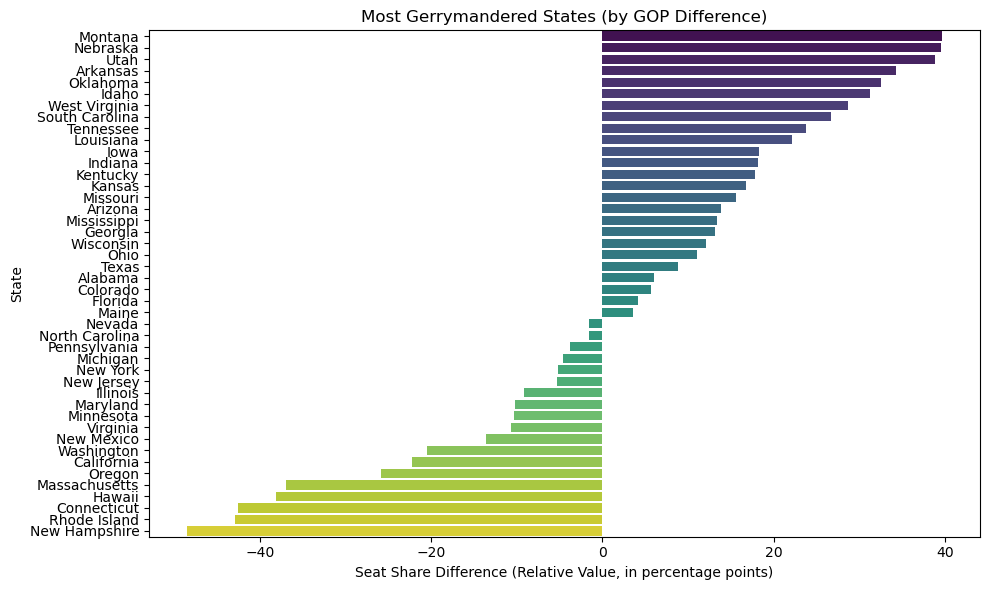

In [223]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

df = df.sort_values(by='GOP Difference Rel (%)', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=df[df['Total Seats'] > 1], x='GOP Difference Rel (%)', y='State', palette='viridis')

plt.title('Most Gerrymandered States (by GOP Difference)')
plt.xlabel('Seat Share Difference (Relative Value, in percentage points)')
plt.ylabel('State')
plt.tight_layout()
plt.show()

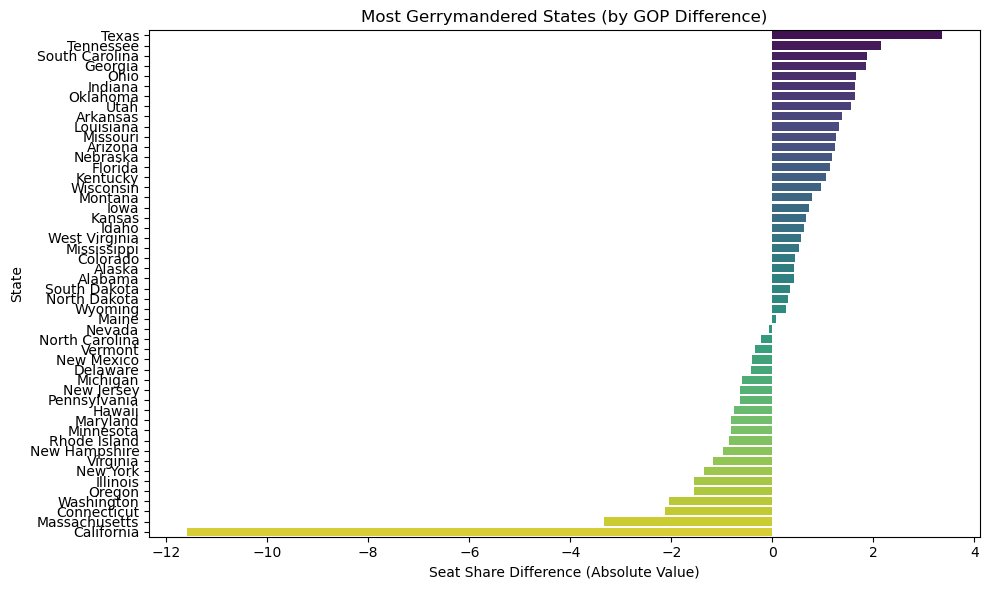

In [224]:
df = df.sort_values(by='GOP Difference Abs', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='GOP Difference Abs', y='State', palette='viridis')

plt.title('Most Gerrymandered States (by GOP Difference)')
plt.xlabel('Seat Share Difference (Absolute Value)')
plt.ylabel('State')
plt.tight_layout()
plt.show()

In [225]:
stdf = df[['State', 'Total Seats']].copy()
stdf['Total Votes'] = df['TRUMP'] + df['HARRIS']
stdf['Weight'] = (stdf['Total Votes'] / stdf['Total Seats']).astype(int)
stdf['Weight Relative'] = 1 / (stdf['Weight'] * (1 / stdf['Weight'].max()))


In [226]:
gop_gerrymandered = df['GOP Difference Abs'].apply(lambda ele: ele if ele > 0 else 0).sum()
dem_gerrymandered = df['GOP Difference Abs'].apply(lambda ele: -ele if ele < 0 else 0).sum()
gop_diff = gop_gerrymandered - dem_gerrymandered
(gop_gerrymandered, dem_gerrymandered, gop_diff)

(31.4927, 32.3243, -0.8316000000000017)

In [227]:
gop_diff_word = "more" if gop_diff > 0 else "less"
text = (
    f"Overall Dems have gerrymandered extra **{round(dem_gerrymandered, 4)}** seats from fair distribution "
    f"while Republicans did gerrymander **{round(gop_gerrymandered, 4)}** extra seats around american states which is "
    f"**{round(abs(gop_diff), 4)} {gop_diff_word}**."
)
display(Markdown(text))

Overall Dems have gerrymandered extra **32.3243** seats from fair distribution while Republicans did gerrymander **31.4927** extra seats around american states which is **0.8316 less**.

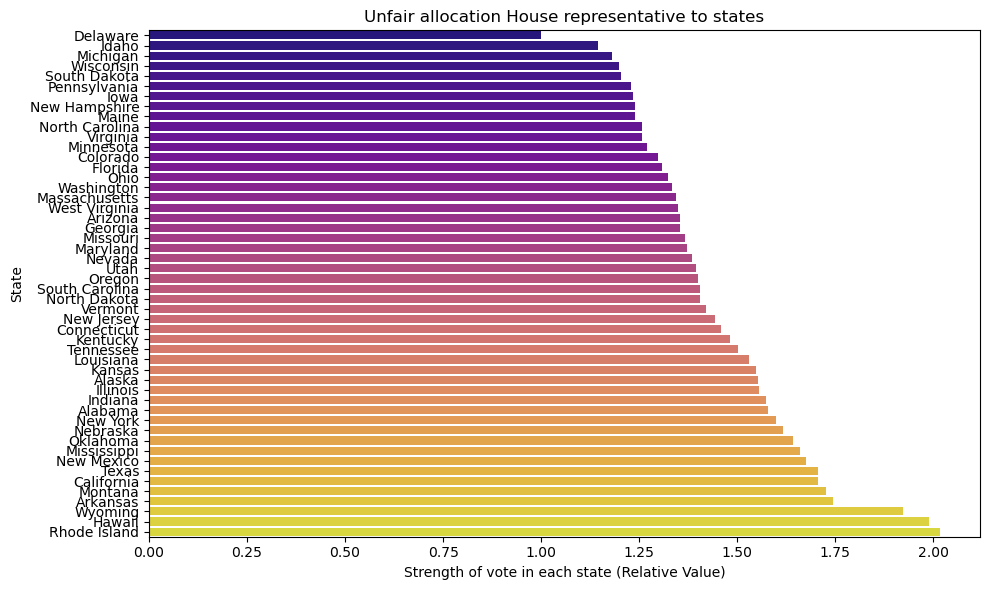

In [228]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=stdf.sort_values('Weight Relative'),
    x='Weight Relative',
    y='State',
    hue='State',             
    palette='plasma',          
    dodge=False,                
    legend=False                
)
plt.title('Unfair allocation House representative to states')
plt.xlabel('Strength of vote in each state (Relative Value)')
plt.ylabel('State')
plt.tight_layout()
plt.show()